## Berry vs Grape Image Classification

*This notebook is largely based on [this tutorial](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) from [fast.ai](https://www.fast.ai/)*

What it aims to do is classify a picture of berries as blue, black or grapes. This is just so I can see how good it can become at differentiating between similar looking images. 

In [1]:
from fastai.vision import *

**Get images from google**

1. Search Google Images & load all the images you want
2. Enter the following code after pressing `cmd-Opt-j`
>`urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));` <br> `window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

**Create directories for images**

In [2]:
folder = 'blue'
file = 'blueberries.csv'

In [3]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
folder = 'grape'
file = 'grapes.csv'

In [6]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
folder = 'black'
file = 'blackberries.csv'

In [ ]:
path = Path('data/berries')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
path.ls()

[PosixPath('data/celeb/celebrity'), PosixPath('data/celeb/non-celebrity')]

In [8]:
classes = ['blue','grape','black']

*Next, place the* **csv files** *into the* **directory**

**Downloading the Images**

*Note: If it doesn't work the first time, add max_workers = 0 to debug*

In [9]:

path = Path('data/berries')
folder = 'blue'
file = 'blueberries.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

path = Path('data/berries')
folder = 'grape'
file = 'grapes.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

path = Path('data/berries')
folder = 'black'
file = 'blackberries.csv'
dest = path/folder
download_images(path/file, dest, max_pics=200)

**Cleaning up the images**

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

celebrity


non-celebrity


**Loading the images as data**

In [11]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=2).normalize(imagenet_stats)

In [12]:
data.classes

['celebrity', 'non-celebrity']

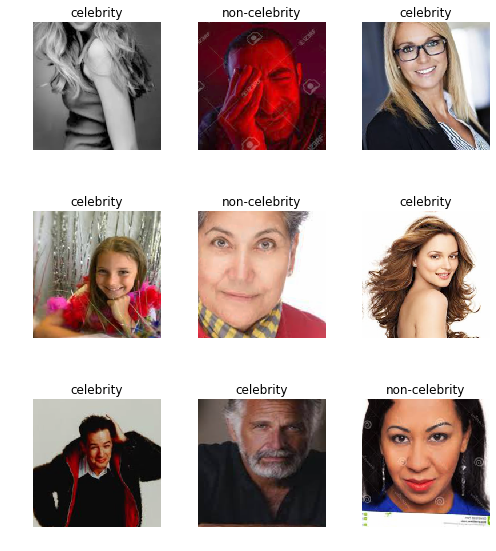

In [13]:
data.show_batch(rows=3, figsize=(7,8))


In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['celebrity', 'non-celebrity'], 2, 320, 80)

**Train Model**

In [15]:
model = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.334501,0.899149,0.375000,00:05
1,1.037931,1.612657,0.400000,00:03
2,0.887936,1.323436,0.312500,00:03
3,0.773652,1.115632,0.312500,00:03


In [17]:
model.save('model-1')


*The model appears to have a learning rate that is too low as the validation loss is greater than the training loss at points, indicating that we aren't fitting the data enough*

In [18]:
model.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


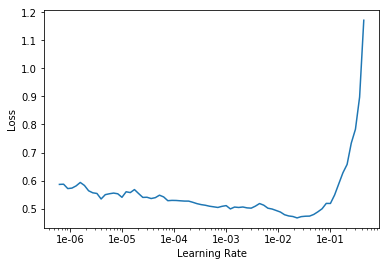

In [19]:
model.recorder.plot()


In [23]:
model.fit_one_cycle(5, max_lr=slice(1e-03,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.187428,0.942903,0.275000,00:03
1,0.180430,1.021243,0.275000,00:03
2,0.183377,1.025496,0.262500,00:03
3,0.166393,1.151478,0.237500,00:03
4,0.161332,1.115199,0.237500,00:03


In [24]:
model.save('model-2')

In [25]:
model.unfreeze()

In [26]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


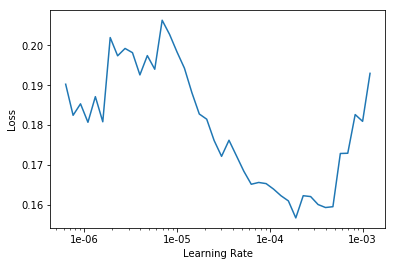

In [27]:
model.recorder.plot()

In [28]:
model.fit_one_cycle(3, max_lr=slice(3e-5,3e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.197009,0.989293,0.237500,00:04
1,0.191483,1.249709,0.312500,00:04
2,0.185999,1.280655,0.312500,00:04


In [29]:
model.save('model-3')

Our model with the lowest error_rate appears to be model 2. <br>
**Let's load this model and see what the results indicate.**

In [31]:
model.load('model-2');

In [32]:
interp = ClassificationInterpretation.from_learner(model)

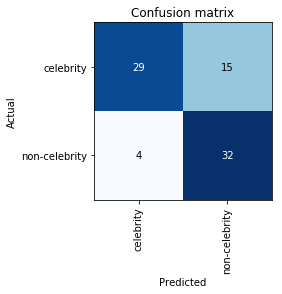

In [33]:
interp.plot_confusion_matrix()

*It appears that our model predicts people celebrities as non-celebrities more often than the predicting non-celebrities as celebrities.*
*Let's visualize some of these errors*

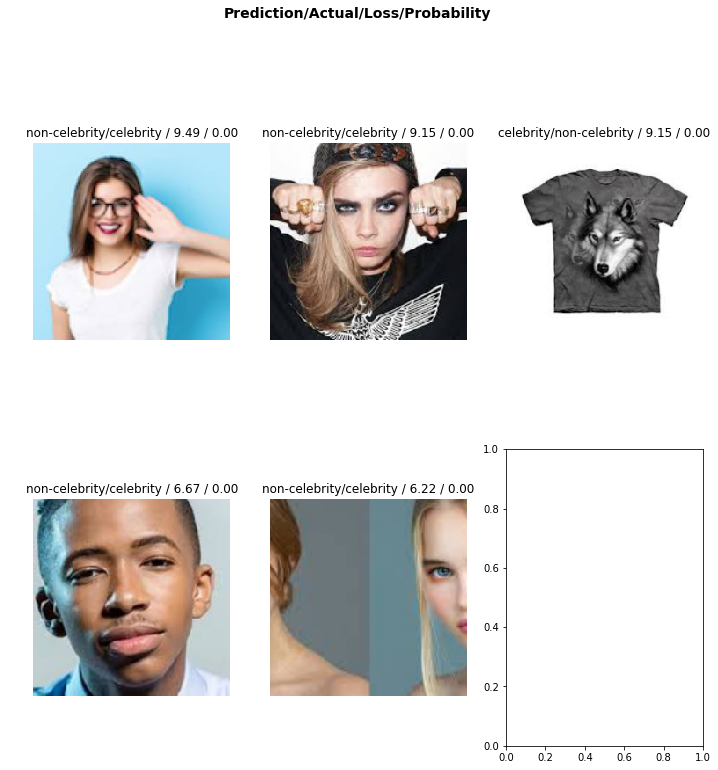

In [36]:
interp.plot_top_losses(k=5)

*As we can see, some of these make sense as they are really noisy photos... let's clean up the photos and then, see how our model performs*

### Cleaning Up

In [39]:
from fastai.widgets import *

In [41]:
#not quite sure what this is doing
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [43]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('model-2');

In [44]:
#not sure what this does
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [45]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

*Now that we have cleaned our dataset, we must recreate our model from the cleaned.csv file*

In [48]:
path = Path('data/berries')
np.random.seed(42)
cleaned_data = ImageDataBunch.from_csv(path, size=224, valid_pct=0.2,
    ds_tfms=get_transforms(), csv_labels='cleaned.csv').normalize(imagenet_stats)

In [52]:
cleaned_data.classes

['celebrity', 'non-celebrity']

In [53]:
cleaned_data.classes, cleaned_data.c, len(cleaned_data.train_ds), len(cleaned_data.valid_ds)


(['celebrity', 'non-celebrity'], 2, 302, 75)

In [54]:
clean_model = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [55]:
clean_model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.326101,1.053406,0.400000,00:04
1,1.036852,1.376687,0.426667,00:03
2,0.902953,1.056261,0.333333,00:03
3,0.786059,0.875284,0.293333,00:03


In [ ]:
clean_model.save('model-1')

In [65]:
clean_model.load('model-1');

In [66]:
clean_model.unfreeze()

In [58]:
clean_model.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


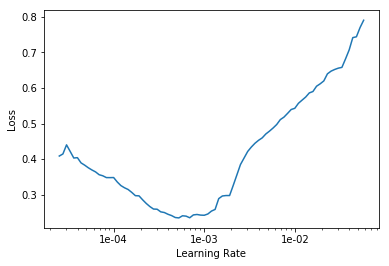

In [60]:
clean_model.recorder.plot()

In [67]:
clean_model.fit_one_cycle(1, max_lr=slice(1e-4,5e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.523586,0.658246,0.213333,00:04


In [68]:
clean_model.save('model-2')

In [69]:
clean_model.fit_one_cycle(2, max_lr=slice(1e-4,5e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.409237,0.779474,0.200000,00:04
1,0.373385,0.774910,0.213333,00:04


*So it appears our best error_rate is 0.2, so 1/5 will be classified wrong while randomly 2.5/5 would be classified wrong. This isn't a great result, which makes sense given that the data is quite noisy and celebrities are regular people, so apart from the fancier photos and make up, they shouldn't differ too much from everyone else.*"

### Let's put it into use 
We are going to check if it can predict whether one of my favorite artists, Maggie Rogers, is classified as a celebrity or not. To be honest, I'm not even sure. She seems so down to Earth. 

In [70]:
clean_model.export()

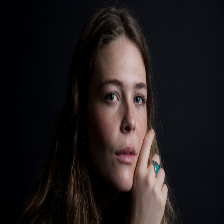

In [80]:
img = open_image(path/'maggie.jpg')
img = img.resize(224)
img

In [82]:
learn = load_learner(path)

In [92]:
pred_class,pred_idx,outputs = learn.predict(img)
outputs 

tensor([0.0013, 0.9987])

This means it predicts her as belonging to the 2nd class, which is non-celebrities. Hmmm. <br> Shame it's wrong, or maybe I'll end this by saying:       **She's one of us!**